In [8]:
#import packages
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer

In [9]:
#set the style
sns.set(style = "whitegrid")

In [10]:
#download NLTK resources
nltk.download("punkt")
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

try:
    nltk.data.find("tokenizers/punkt_tab")
except LookupError:
    try:
        nltk.download("punkt_tab")
    except:
        pass 

try:
    nltk.data.find("corpora/wordnet")
except LookupError:
    nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\пк\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
#load the data
df = pd.read_csv("linkedin_reviews_clean.csv")

#keep only necessary rows, drop empties
df = df[["country", "review_clean", "sentiment_vader"]].dropna(subset = ["review_clean", "country", "sentiment_vader"])
df = df[df["review_clean"].str.strip().astype(bool)]

#countries of interest
COUNTRIES = ["us", "gb", "it", "fi", "kz"]
df = df[df["country"].isin(COUNTRIES)]
df.head()

,country,review_clean,sentiment_vader
0,us,wow amazing,positive
1,us,Very professional.,neutral
2,us,excellent in making,positive
4,us,All video network systems and mobile model SM ...,neutral
5,us,great app,positive


In [12]:
#text preprocessing helpers

lemmatizer = WordNetLemmatizer()

#domain stopwords
DOMAIN_STOP = set("""
app apps login log sign signing signed account accounts linkedin li nked in update updates updated version versions
phone phones device devices android google play store bug bugs crash crashes issue issues problem problems ad ads
""".split())

#basic English stopwords
EN_STOP = set("""
a an the and to for of in on with is are was were be been have has had it this that i you they he she we my your our
from at by as not no or but if so than then too very can could should would will just more most least also
""".split())

STOP = DOMAIN_STOP | EN_STOP

TOKENIZER = nltk.word_tokenize

def tokenize(text):
    toks = [t.lower() for t in TOKENIZER(text)]
    #keep alphabetic tokens only
    toks = [re.sub(r"[^a-z]", "", t) for t in toks]
    toks = [t for t in toks if t and t not in STOP and len(t) > 2]
    #lemmatize
    toks = [lemmatizer.lemmatize(t) for t in toks]
    return toks

In [13]:
#core function: top words by (country, sentiment)
def top_words_by_group(df, group_cols = ("country","sentiment_vader"), text_col = "review_clean", top_n = 20, min_reviews = 50):
    rows = []
    grouped = df.groupby(list(group_cols), dropna = False)
    for g, sub in grouped:
        if len(sub) < min_reviews:
            continue  #skip tiny samples to avoid noisy charts
        toks = []
        for txt in sub[text_col].tolist():
            toks.extend(tokenize(txt))
        cnt = Counter(toks).most_common(top_n)
        for rank, (word, count) in enumerate(cnt, 1):
            rows.append({**{c: v for c, v in zip(group_cols, g)}, "word": word, "count": count, "rank": rank, "n_reviews": len(sub)})
    return pd.DataFrame(rows)

In [14]:
#run and export
top_df = top_words_by_group(df, group_cols = ("country", "sentiment_vader"), top_n = 15, min_reviews = 50)
top_df.to_csv("top_words_by_country_sentiment.csv", index = False)
top_df.head(10)

,country,sentiment_vader,word,count,rank,n_reviews
0,fi,negative,job,70,1,339
1,fi,negative,restricted,53,2,339
2,fi,negative,worst,52,3,339
3,fi,negative,even,44,4,339
4,fi,negative,one,43,5,339
5,fi,negative,still,40,6,339
6,fi,negative,any,39,7,339
7,fi,negative,all,39,8,339
8,fi,negative,get,39,9,339
9,fi,negative,what,39,10,339


In [15]:
#plot helper
def plot_top_words(sub, title, outfile):
    plt.figure(figsize = (7, 5))
    sub = sub.sort_values("count", ascending = True)
    plt.barh(sub["word"], sub["count"])
    plt.title(title)
    plt.xlabel("Count"); plt.ylabel("")
    plt.tight_layout()
    plt.savefig(outfile, dpi = 300, bbox_inches = "tight")
    plt.show()

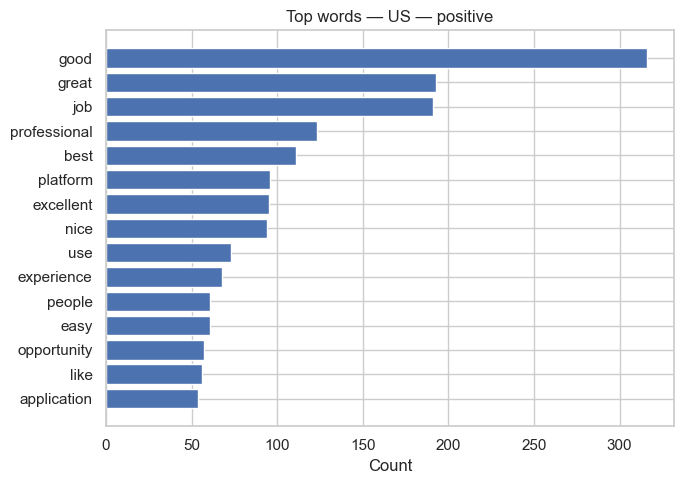

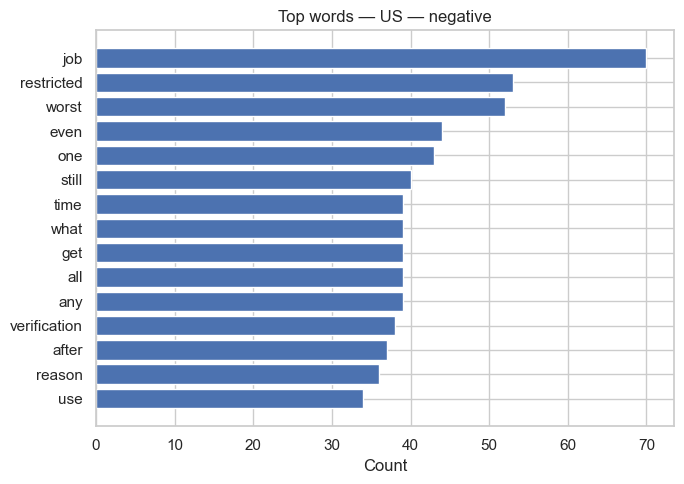

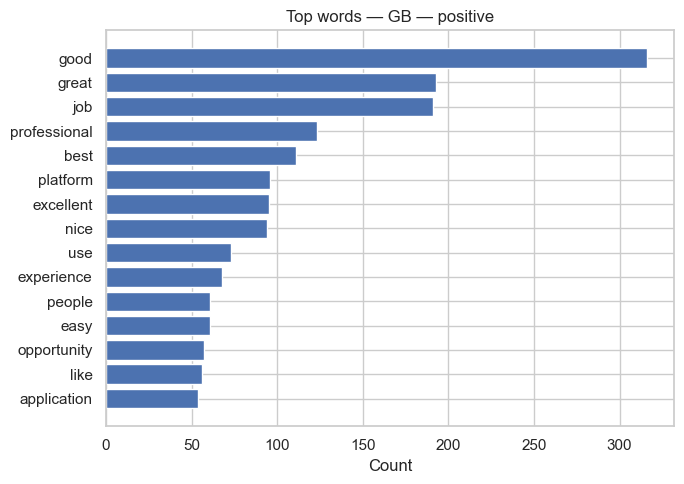

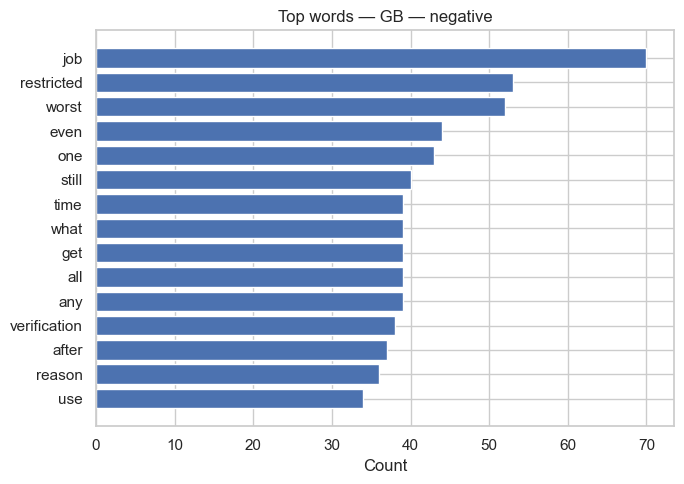

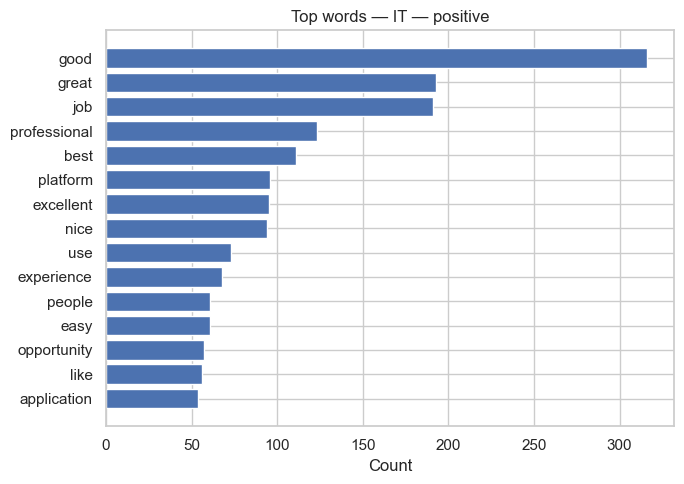

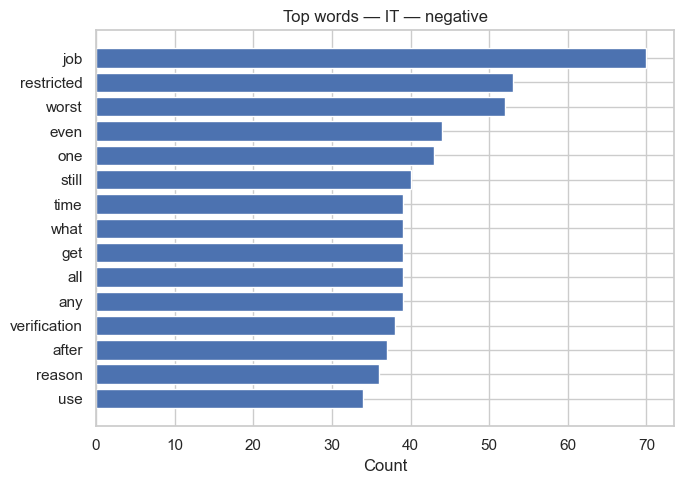

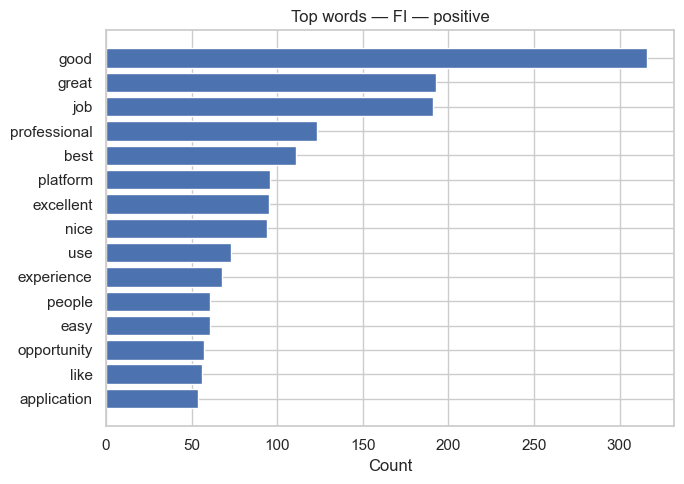

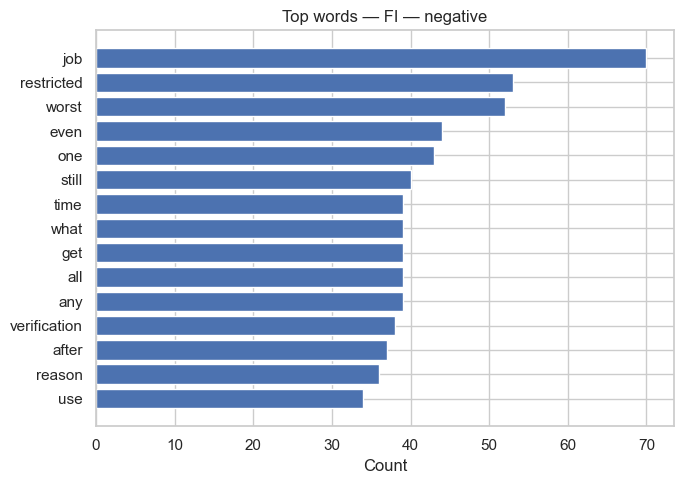

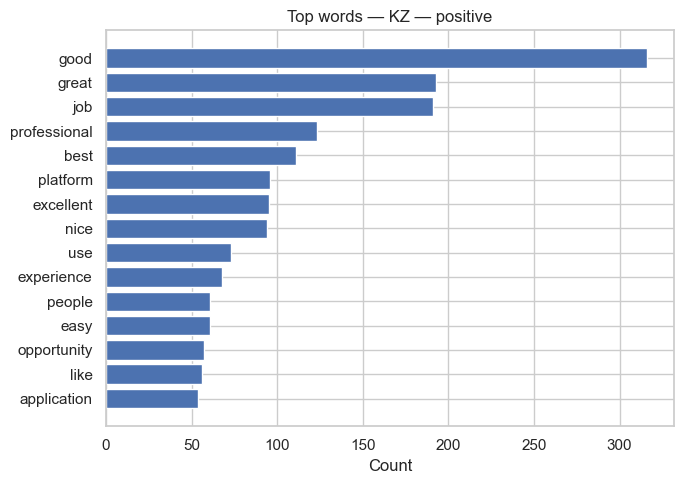

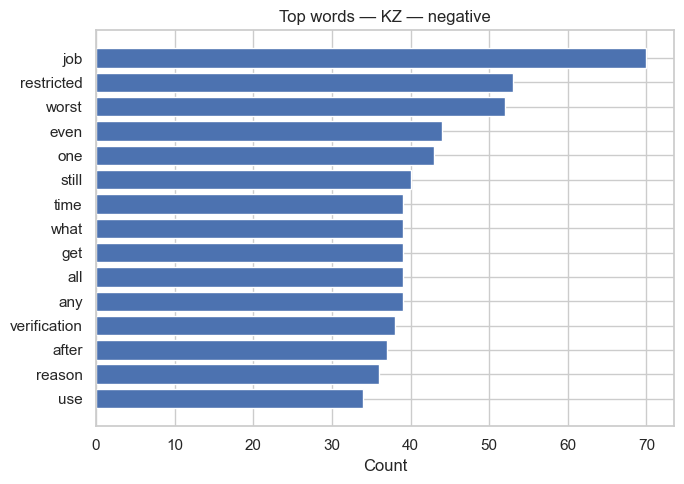

In [17]:
#generate per-country plots for positive and negative sentiments
for c in COUNTRIES:
    for s in ["positive", "negative"]:
        sub = top_df[(top_df["country"] == c) & (top_df["sentiment_vader"] == s)]
        if sub.empty:
            continue
        title = f"Top words — {c.upper()} — {s}"
        outfile = f"images/top_words_{c}_{s}.png"
        plot_top_words(sub[["word", "count"]], title, outfile)